X_df_numerico_polyYa hemos realizado un análisis exploratorio durante la primera parte del trabajo práctico. En este notebook se volverá a retomar dicho análisis para lograr conseguir un *preprocesamiento* de datos con mayor calidad de tal forma que nuestros modelos de aprendizaje automático que aplicaremos, puedan aprender mejor sobre el conjunto de datos a presentarles. Ademas no queremos que nos devuelvan basura. Tal como dice el refrán:

"**Garbage in... garbage out**"

Profundizaremos en diferentes técnicas de la *Ingeniería de Features* que no hemos tratado en la primera parte del trabajo práctico y nos será de muchísima utilidad para la hora de exportar nuestros preprocesamientos en el fichero **preprocessing.py** solicitado. 

In [1]:
from functools import lru_cache
import dtreeviz.trees as dtreeviz
import graphviz
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
import ipywidgets as widgets
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import pandas as pd
from IPython.display import SVG, display
from ipywidgets import Button, IntSlider, interactive
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from sklearn import preprocessing, tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import (
    KBinsDiscretizer,
    MinMaxScaler,
    Normalizer,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)
from sklearn.model_selection import StratifiedShuffleSplit, KFold, StratifiedKFold
sns.set()

from preprocessing import obtener_datasets
from preprocessing import aplicar_preparacion
from preprocessing import graficar_matriz_confusion
from preprocessing import conversion_numerica

In [2]:
from sklearn.feature_selection import VarianceThreshold

def filter_by_variance(df, threshold):
    cols_con_varianza = df.var().index.values
    _df = df[cols_con_varianza].copy()
    selector = VarianceThreshold(threshold=threshold)
    vt = selector.fit(_df)
    _df = _df.loc[:, vt.get_support()]
    return _df


# Expansión dataset: Polynomial de Features

In [3]:
from sklearn.preprocessing import PolynomialFeatures

Vamos a definir la función para expandir el dataset de entrenamiento con Polynomial de Features.


Lo haremos en el caso de nuestras 4 distribuciones numéricas.
No tendria sentido aplicar un OneHotEncoding sobre las features categoricas y luego un Polynomial de Features sobre la misma, pues podria generarnos ruido en nuestros modelos con muchas nuevas features entre numericas y las que solo contienen entre 0's y 1's



In [4]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)

X_numerico_puro = X_df_r[['anios_estudiados', 'edad', 'suma_declarada_bolsa_argentina', 'horas_trabajo_registradas']]
X_numerico_puro.describe()

,anios_estudiados,edad,suma_declarada_bolsa_argentina,horas_trabajo_registradas
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,14.053868,38.581647,990.345014,40.437456
std,2.664488,13.640433,7408.986951,12.347429
min,1.000000,17.000000,-4356.000000,1.000000
25%,13.000000,28.000000,0.000000,40.000000
50%,14.000000,37.000000,0.000000,40.000000
75%,16.000000,48.000000,0.000000,45.000000
max,20.000000,90.000000,99999.000000,99.000000


In [5]:
poly = PolynomialFeatures(2, interaction_only = False)
X_numerico_puro_poly = pd.DataFrame(poly.fit_transform(X_numerico_puro))  
X_numerico_puro_poly.shape

(32561, 15)

Filtramos aquelas features que mantengan varianza cero.

In [6]:
X_numerico_puro_poly = filter_by_variance(X_numerico_puro_poly, 0)
X_numerico_puro_poly.shape

(32561, 14)

En conclusion, generaremos la siguente funcion que se encontrará en el archivo *preprocessing.py*, el cual generará nuevas features segun las 4 nuevas features numericas acorde a un PolynomialFeatures, donde se le podrá indicar el grado y el intercation_only para permitir o no potencias entre features. 
Además limpirá las features que hayan mantenido una varianza igual a cero.


In [7]:
def get_dataframe_polynomial(df, grade_r, interaction_only_r):
    """
    Recibe el dataset con el preprocesamiento aplicado por la función de 'aplicar_preparacion()'
    
    Retorna el dataset recibido agregandole las nuevas features generadas a partir de PolynomialFeature segun el grado especificado.
    También se le puede indicar si se prefiere hacer potencias entre las nuevas features mediante el booleano 'interaction_only_r'.
    """
    print('Dataset inicial con', len(df.columns), 'features...')

    to_expand = df[['anios_estudiados', 'edad', 'suma_declarada_bolsa_argentina', 'horas_trabajo_registradas']]
    df_old = df.drop(columns =['anios_estudiados', 'edad', 'suma_declarada_bolsa_argentina', 'horas_trabajo_registradas'] )
    poly = PolynomialFeatures(grade_r, interaction_only = interaction_only_r)
    df_expand = pd.DataFrame(poly.fit_transform(to_expand))
    df_expand = filter_by_variance(df_expand, 0)
    df_final = pd.concat([df_expand,df_old], axis=1)
    print('Dataset nuevo con PolynomialFeature con', len(df_final.columns), 'features...')
    return df_final

In [8]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)

get_dataframe_polynomial(X_df_r, 2, False)

Dataset inicial con 11 features...
Dataset nuevo con PolynomialFeature con 21 features...


,1,2,3,4,5,6,7,8,9,10,...,12,13,14,categoria_de_trabajo,educacion_alcanzada,estado_marital,genero,religion,rol_familiar_registrado,trabajo
0,17.0,39.0,2174.0,40.0,289.0,663.0,36958.0,680.0,1521.0,84786.0,...,4726276.0,86960.0,1600.0,empleado_publico,"Universitario - [1,3] anio",sin_matrimonio,hombre,cristianismo,sin_familia,entretenimiento
1,17.0,50.0,0.0,13.0,289.0,850.0,0.0,221.0,2500.0,0.0,...,0.0,0.0,169.0,monotibutista,"Universitario - [1,3] anio",matrimonio_civil,hombre,cristianismo,casado_a,directivo_gerente
2,13.0,38.0,0.0,40.0,169.0,494.0,0.0,520.0,1444.0,0.0,...,0.0,0.0,1600.0,relacion_de_dependencia,"Secundario - (3,6] anio",divorciado_a,hombre,cristianismo,sin_familia,limpiador
3,11.0,53.0,0.0,40.0,121.0,583.0,0.0,440.0,2809.0,0.0,...,0.0,0.0,1600.0,relacion_de_dependencia,"Secundario - [1,3] anio",matrimonio_civil,hombre,judaismo,casado_a,limpiador
4,17.0,28.0,0.0,40.0,289.0,476.0,0.0,680.0,784.0,0.0,...,0.0,0.0,1600.0,relacion_de_dependencia,"Universitario - [1,3] anio",matrimonio_civil,mujer,judaismo,casado_a,profesional_especializado
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,16.0,27.0,0.0,38.0,256.0,432.0,0.0,608.0,729.0,0.0,...,0.0,0.0,1444.0,relacion_de_dependencia,"Universitario - [1,3] anio",matrimonio_civil,mujer,cristianismo,casado_a,soporte_tecnico
32557,13.0,40.0,0.0,40.0,169.0,520.0,0.0,520.0,1600.0,0.0,...,0.0,0.0,1600.0,relacion_de_dependencia,"Secundario - (3,6] anio",matrimonio_civil,hombre,cristianismo,casado_a,inspector
32558,13.0,58.0,0.0,40.0,169.0,754.0,0.0,520.0,3364.0,0.0,...,0.0,0.0,1600.0,relacion_de_dependencia,"Secundario - (3,6] anio",viudo_a,mujer,cristianismo,soltero_a,entretenimiento
32559,13.0,22.0,0.0,20.0,169.0,286.0,0.0,260.0,484.0,0.0,...,0.0,0.0,400.0,relacion_de_dependencia,"Secundario - (3,6] anio",sin_matrimonio,hombre,cristianismo,con_hijos,entretenimiento


Tambien definiremos una función que expanda todas las features, no solo las 4 numericas de nuestro dataset.

In [9]:
def get_dataframe_polynomial_all(df: pd.DataFrame, grade: np.uint8, interaction_only: bool):
    """ 
    Expande el dataset con PolynomialFeatures teniendo en cuenta todas las columnas del dataset recibido.
    
    Parametros recibidos
    --------
        df -> pd.DataFrame: El dataset obtenido mediante 'obtener_datasets()'.
        grade -> np.uint8: el numero de grado para aplicar con PolynomialFeatures
        interaction_only -> bool: indicador para para las potencias entre las nuevas features mediante

    Retorno
    --------
        df_poly -> pd.DataFrame: retorna el dataset recibido agregandole las nuevas features generadas a partir de PolynomialFeature segun los parametros recibidos.
    """
    
    print('Dataset inicial con', len(df.columns), 'features...')
    poly = PolynomialFeatures(grade, interaction_only = interaction_only)
    df_expand = pd.DataFrame(poly.fit_transform(df))
    df_expand = filter_by_variance(df_expand, 0)
    print('Dataset nuevo con PolynomialFeature con', len(df_expand.columns), 'features...')
    return df_expand  

# Buscando reducir dimensionalidad

## Busquemos reducir dimensionalidad con algún escalado de los datos

Definamos la siguiente función que reduzca la dimensionalidad. Utilzaremos TruncatedSVD para reducir lo mismo el cual realiza una reducción via la descomposición de valores singulares.

**Chamuyar más sobre TruncatedSVD**

Pero antes de reducir la dimensionalidad, apliquemos diferentes escalado de los datos para saber cual reducción nos mantiene un mayor porcentaje de varianza.

In [10]:
def graficar_reducciones_con_preprocesamientos(df,var_deseada):
    scalers = [
        StandardScaler(),
        MinMaxScaler(),  
        RobustScaler(), 
        PowerTransformer(), 
        Normalizer(),
    ]

    fig, ax = plt.subplots(dpi=110)
    for count, scaler in enumerate(scalers):
        print("----------------------------------------------------------------------------")
        print("Buscando reducción de dimensionalidad con preprocesamiento de", scaler)

        scaled = scaler.fit_transform(df)
        X_df_scaled = pd.DataFrame(scaled, index=df.index, columns=df.columns)
        
        svd = TruncatedSVD(n_components=df.shape[1]-1, n_iter=10, random_state=10)
        svd.fit(X_df_scaled)

        var_cumu = np.cumsum(svd.explained_variance_ratio_) * 100
        k = np.argmax(var_cumu > var_deseada)
        
        print("El numero minimo de componentes para explicar el",var_deseada, "% de la varianza es: " + str(k))
        if count == 4:
            print("----------------------------------------------------------------------------\n")

        ax.set_title('Varianza acumulada explicada por componente')
        ax.set_ylabel('Varianza acumulada explicada')
        ax.set_xlabel('Componentes principales')
    
        axes = ax.plot(var_cumu, label = scaler)
        ax.legend()
        ax.axhline(y=85, color="r", linestyle="--")


Aplicando 'conversion_numerica' en las variables categóricas.
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de StandardScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 31
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de MinMaxScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 22
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de RobustScaler()
El numero minimo de componentes para explicar el 95 % de la varianza es: 0
----------------------------------------------------------------------------
Buscando reducción de dimensionalidad con preprocesamiento de PowerTransformer()
El numero minimo de componentes para explicar el 95 % de la varianza es: 31
-------------

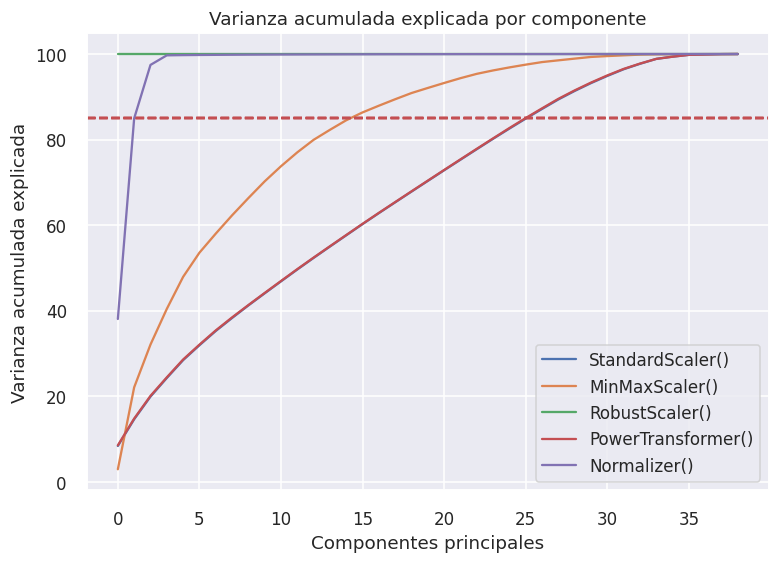

In [11]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 

graficar_reducciones_con_preprocesamientos(X_df_numerico, 95)

Aquella transformación con la que logramos mantener un 95% de varianza es la MinMaxScaler() con un numero de componentes menor, de 23. 

**(DUDANDO)** Tiene sentido que con al Normalizer() hayamos obtenido solamente 2 componentes pues estan todos los valores normalizado. Si se piensa en un grafico 2D es como si se proyectase ese circulo unitario (formado gracias a una Normalización) sobre los ejes en 2 dimensiones, es decir, sobre 2 componentes principales de los ejes.


Nos quedaremos entonces con el escalado de los datos de *MinMaxScaler()* aplicando TruncatedSVD con 23 compoenntes a reducir. 

Definimos dicha función que dejaremos lista en el *preprocessing.py*

In [12]:
def reduccion_numerica(df, varianza_explicada = 0.95):
    """
        Recibe el dataset con el preprocesamiento aplicado por la función de 'aplicar_preparacion()' y, 'conversion_numerica' ó 'conversion_numerica_generalizada'

        Reduce la dimensionalidad del dataset recibido mediante TruncatedSVD manteniendo un 95% de varianza con 23 compoenntes por default.
        Antes de aplicar TruncatedSVD, se re-escala los datos mediante MinMaxScaler().
        
        También se puede recibir la cantidad de varianza explicada.
    """
    scaled = MinMaxScaler().fit_transform(df)
    X_df_numerico_scaled = pd.DataFrame(scaled)
    print("Aplicando MinMaxScaler previo al TruncatedSVD...")
    svd = TruncatedSVD(n_components=X_df_numerico_scaled.shape[1]-1, n_iter=10, random_state=10)
    svd.fit(X_df_numerico_scaled)

    var_cumu = np.cumsum(svd.explained_variance_ratio_) 
    k = np.argmax(var_cumu > varianza_explicada )
        
    svd = TruncatedSVD(n_components=k +1 , n_iter=10, random_state=10)
    X_df_numerico_scaled_svd = pd.DataFrame(svd.fit_transform(X_df_numerico_scaled))
    print('TruncatedSVD aplicado con',  k+1, 'componentes finales se explica una varianza de: %.10f' % svd.explained_variance_ratio_.sum())
    return X_df_numerico_scaled_svd

In [13]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r) 
X_reducida = reduccion_numerica(X_df_numerico, 0.95)

Aplicando 'conversion_numerica' en las variables categóricas.
Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 23 componentes finales se explica una varianza de: 0.9536277314


El cual podemos comprobar sus 23 componetes solicitandole 0.95 de varianza explicada.

In [14]:
X_reducida.shape

(32561, 23)

## Revisemos con t-SNE como quedó esta reducción

Puede tardar un poco por tratarse de muchos datos.

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=35, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_reducida)  

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.121s...
[t-SNE] Computed neighbors for 32561 samples in 14.522s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for s

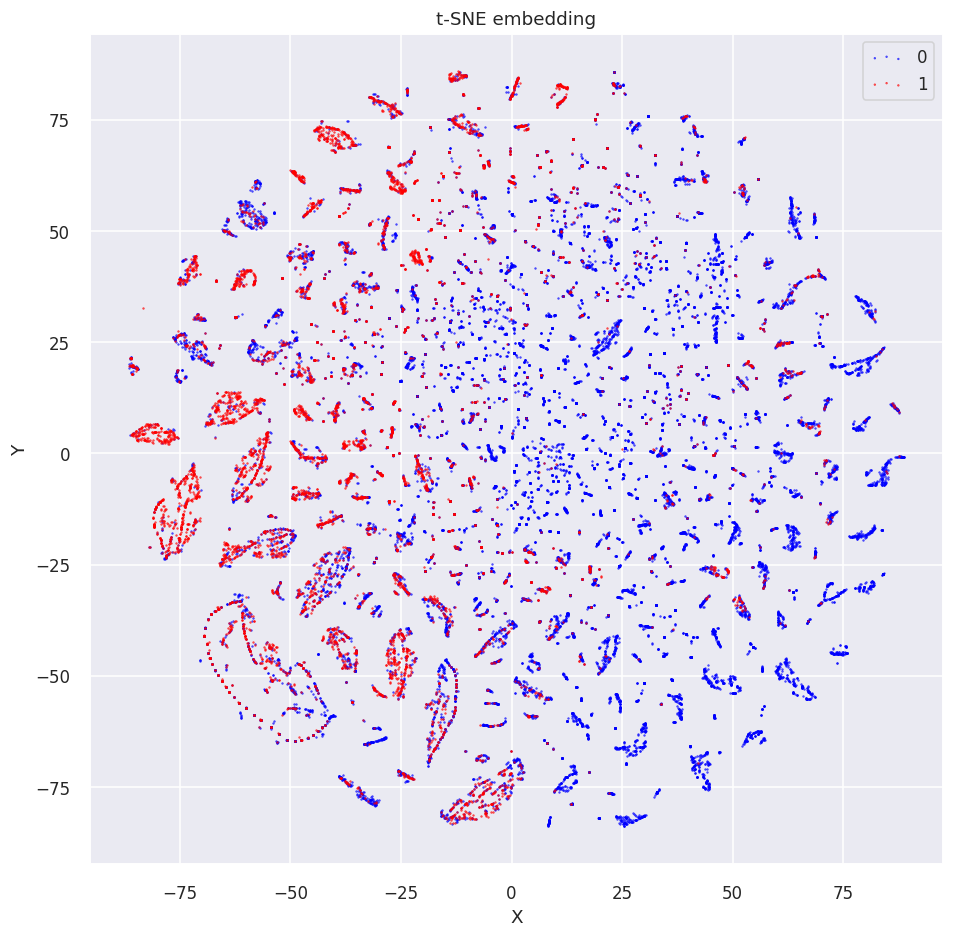

In [16]:
colors = ['blue', 'red']
target_names = np.unique(y_df_r)

plt.figure(2, figsize=(10, 10), dpi = 110)

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y_df_r == i, 0], X_tsne[y_df_r == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('t-SNE embedding')
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('t-SNE_23_components', dpi=150)
plt.show()

# Busquemos expandir y reducir [RECORDAR CREAR LA FUNCION Y USARLA EN SVM]

Expandamos:

In [17]:
df, df_for_prediction = obtener_datasets()
X_df_r, y_df_r = aplicar_preparacion(df)
X_df_numerico = conversion_numerica(X_df_r)
X_poly = get_dataframe_polynomial(X_df_numerico, 2, False)

Aplicando 'conversion_numerica' en las variables categóricas.
Dataset inicial con 40 features...
Dataset nuevo con PolynomialFeature con 50 features...


Luego pasamos a reducir:

In [18]:
X_poly_red = reduccion_numerica(X_poly, 0.95)

Aplicando MinMaxScaler previo al TruncatedSVD...
TruncatedSVD aplicado con 24 componentes finales se explica una varianza de: 0.9520266151


In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=35, method='barnes_hut', n_iter=1000, verbose=1)
X_tsne = tsne.fit_transform(X_poly_red)  

[t-SNE] Computing 106 nearest neighbors...
[t-SNE] Indexed 32561 samples in 0.106s...
[t-SNE] Computed neighbors for 32561 samples in 21.768s...
[t-SNE] Computed conditional probabilities for sample 1000 / 32561
[t-SNE] Computed conditional probabilities for sample 2000 / 32561
[t-SNE] Computed conditional probabilities for sample 3000 / 32561
[t-SNE] Computed conditional probabilities for sample 4000 / 32561
[t-SNE] Computed conditional probabilities for sample 5000 / 32561
[t-SNE] Computed conditional probabilities for sample 6000 / 32561
[t-SNE] Computed conditional probabilities for sample 7000 / 32561
[t-SNE] Computed conditional probabilities for sample 8000 / 32561
[t-SNE] Computed conditional probabilities for sample 9000 / 32561
[t-SNE] Computed conditional probabilities for sample 10000 / 32561
[t-SNE] Computed conditional probabilities for sample 11000 / 32561
[t-SNE] Computed conditional probabilities for sample 12000 / 32561
[t-SNE] Computed conditional probabilities for s

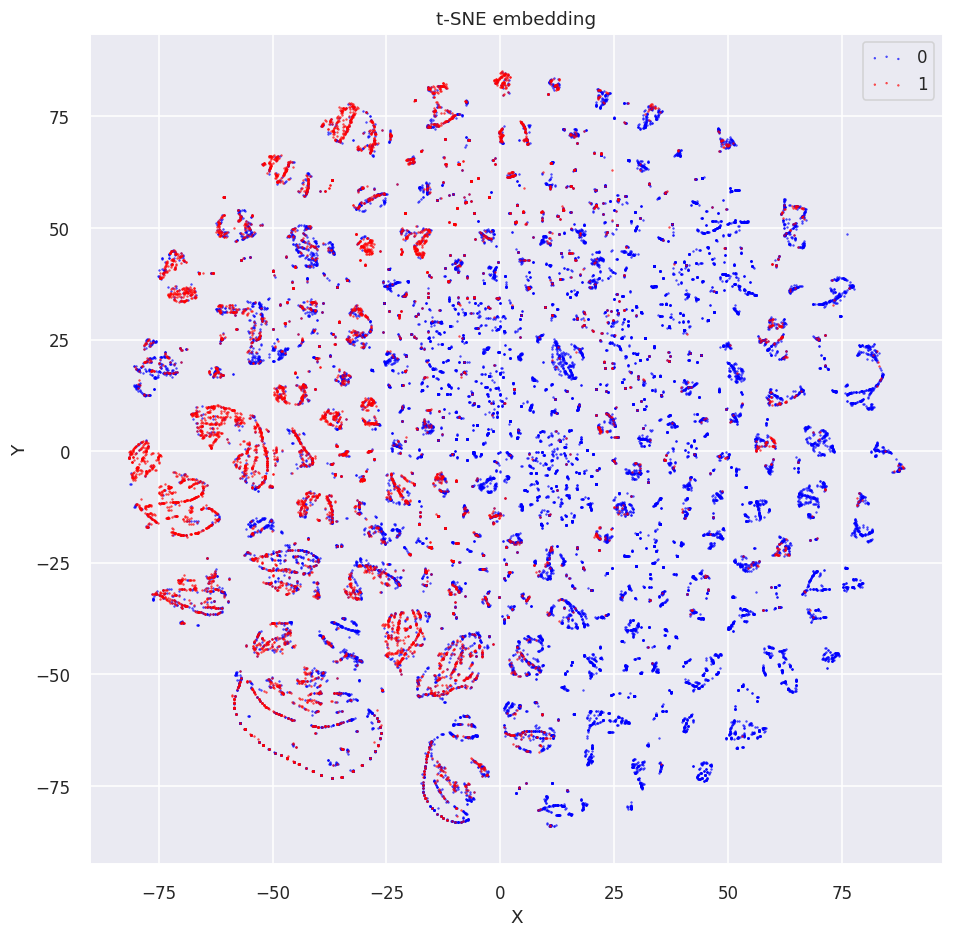

In [20]:
colors = ['blue', 'red']
target_names = np.unique(y_df_r)

plt.figure(2, figsize=(10, 10), dpi = 110)

for color, i, target_name in zip(colors, [0, 1], target_names):
    plt.scatter(X_tsne[y_df_r == i, 0], X_tsne[y_df_r == i, 1], color=color, s=1,
                alpha=.8, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('t-SNE embedding')
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('t-SNE-poly-red', dpi=150)
plt.show()